<a href="https://colab.research.google.com/github/mateuszrusin/ml-filmweb-score/blob/master/oceny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from fwapi.film import Film
import seaborn as sns
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('oceny.csv', parse_dates=['Data'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                1313 non-null   int64         
 1   Tytuł polski      1313 non-null   object        
 2   Tytuł oryginalny  1003 non-null   object        
 3   Rok produkcji     1313 non-null   int64         
 4   Ulubione          3 non-null      object        
 5   Ocena             1313 non-null   object        
 6   Komentarz         0 non-null      float64       
 7   Kraj produkcji    1312 non-null   object        
 8   Gatunek           1313 non-null   object        
 9   Data              1313 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 102.7+ KB


In [8]:
def label_encode(series):
    encoder = LabelEncoder()
    encoder.fit(series)
    return encoder.transform(series)

def multibinarize(series):
    mlb = MultiLabelBinarizer()
    series = series.str.split(",", n = 3)
    data = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=df.index)
    return mlb.classes_, data
    
def movie_info(id):
    try:
        film = Film.get_by_id(id)
        film.populate()
        return film.budget, film.boxoffice, film.topics_count
    except Exception:
        return None, None, None

df = data.drop(columns=['Komentarz'])
df = df[df.Ocena != 'brak oceny']

# comma-separated columns to OneHotEncode
gatunek_classes, gatunek_data = multibinarize(df.Gatunek)
kraj_classes, kraj_data = multibinarize(df['Kraj produkcji'].astype(str))

df[gatunek_classes] = gatunek_data
df[kraj_classes] = kraj_data

df['Ocena'] = df.Ocena.astype('int')

# not needed - column will be delete anyway
df['Ulubione'] = label_encode(df.Ulubione.fillna(''))

# warning - takes long time (a lot filmweb api calls)
new_columns = ['budget', 'boxoffice', 'topics_count']
df[new_columns] = df.apply(lambda x: movie_info(x.ID), axis=1, result_type='expand')
#df[new_columns] = df[new_columns].apply(lambda x: x.fillna(x.mean()), axis=0).astype(int)

df.to_csv(r'oceny_decorated.csv')

df


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,...,Argentyna,Australia,Austria,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count
0,834220,Zoo,NaN,2018,0,6,"Dania, Szwecja","Horror, Komedia",2020-05-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,0,4,Izrael,Dramat,2020-05-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None
2,32178,Kraina Tygrysów,Tigerland,2000,0,7,"Niemcy, USA",Dramat,2020-04-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None
3,774973,Mnie tu nie ma,I'm Not Here,2017,0,7,USA,Dramat,2020-04-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,None,None,None
4,31645,Poza świadomością,Soul Survivors,2001,0,5,USA,"Dramat, Horror",2020-04-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,9509,Shrek,NaN,2001,0,6,USA,"Animacja, Familijny, Komedia",2011-08-04,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,None,None,None
1309,837,Podziemny krąg,Fight Club,1999,0,7,"Niemcy, USA","Thriller, Psychologiczny",2011-08-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None
1310,936,Gladiator,NaN,2000,0,4,"USA, Wielka Brytania",Dramat historyczny,2011-08-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,None,None,None
1311,9136,Requiem dla snu,Requiem for a Dream,2000,0,7,USA,Dramat,2011-08-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,None,None,None


In [11]:
df = pd.read_csv('oceny_decorated.csv', parse_dates=['Data'], index_col=0)

df.topics_count = df.topics_count.fillna(0).astype(int)

def make_groups(df):
    minidf = df.drop(columns=['budget', 'boxoffice', 'ID', 'Gatunek', 'Kraj produkcji', 'Tytuł polski', 'Tytuł oryginalny', 'Data', 'Ulubione'])
    kmeans = KMeans(n_jobs=-1, n_clusters=5, init='k-means++')
    kmeans.fit(minidf)
    return kmeans.predict(minidf)

def fill_mean(column):
    return df.groupby('group')[column].apply(lambda x: x.fillna(x.mean()))

df['group'] = make_groups(df)        
df['budget'] = fill_mean('budget')
df['boxoffice'] = fill_mean('boxoffice')

df = df.drop(columns=['group', 'Data', 'Ulubione'])
df.to_csv(r'oceny_filled.csv')
df

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Argentyna,Australia,Austria,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
2,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
3,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0
4,31645,Poza świadomością,Soul Survivors,2001,5,USA,"Dramat, Horror",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,9509,Shrek,NaN,2001,6,USA,"Animacja, Familijny, Komedia",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0
1309,837,Podziemny krąg,Fight Club,1999,7,"Niemcy, USA","Thriller, Psychologiczny",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
1310,936,Gladiator,NaN,2000,4,"USA, Wielka Brytania",Dramat historyczny,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0
1311,9136,Requiem dla snu,Requiem for a Dream,2000,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0


Baza danych imdb ze strony https://www.imdb.com/interfaces/

In [12]:
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!wget https://datasets.imdbws.com/title.ratings.tsv.gz

--2020-05-02 20:14:28--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.186.49, 13.249.186.34, 13.249.186.93, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.186.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111878702 (107M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 106.70M  46.0MB/s    in 2.3s    

2020-05-02 20:14:30 (46.0 MB/s) - ‘title.basics.tsv.gz’ saved [111878702/111878702]

--2020-05-02 20:14:31--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.186.49, 13.249.186.34, 13.249.186.93, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.186.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5115462 (4.9M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================>]

### Rozpakowywanie

In [0]:
!gzip -d -f title.basics.tsv.gz
!gzip -d -f title.ratings.tsv.gz

### Pobieranie do DataFrame

In [14]:
oceny = df.copy()
oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Argentyna,Australia,Austria,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
2,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
3,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0
4,31645,Poza świadomością,Soul Survivors,2001,5,USA,"Dramat, Horror",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0


otwarcie danych `.tsv` do pliku

In [15]:
imdb_title = pd.read_csv('title.basics.tsv', sep='\t')
imdb_title.tail()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
6768523,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,\N
6768524,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,\N
6768525,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,\N
6768526,tt9916856,short,The Wind,The Wind,0,2015,\N,27,\N
6768527,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,\N


Otwarcie danych z ocenami w imdb

In [16]:
imdb_raiting = pd.read_csv('title.ratings.tsv', sep='\t')
imdb_raiting.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1611
1,tt0000002,6.0,198
2,tt0000003,6.5,1289
3,tt0000004,6.1,121
4,tt0000005,6.1,2058


Połączenie danych ocen i filmu

In [17]:
imdb = pd.merge(imdb_title, imdb_raiting, how='left',on='tconst')
imdb.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,\N,5.6,1611.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,\N,6.0,198.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,\N,6.5,1289.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,\N,6.1,121.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,\N,6.1,2058.0


Przykład filmu o tym samym tytule i tym samym roku.

In [18]:
imdb[(imdb['originalTitle'] == 'Joker')& (imdb['startYear'] == '2019')]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
1547144,tt11010430,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,6.9,8.0
1573201,tt11055460,tvEpisode,Joker,Joker,0,2019,\N,12,\N,7.4,11.0
1580318,tt11067740,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1580322,tt11067748,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1580338,tt11067776,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1581961,tt11070632,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1582168,tt11070984,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1583167,tt11072680,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN
1590818,tt11086026,tvEpisode,Joker,Joker,0,2019,\N,28,\N,7.1,21.0
1616950,tt11131298,tvEpisode,Joker,Joker,0,2019,\N,\N,\N,NaN,NaN


## KONWERSJA kolumn

Do połączenia `pd.merge` wymagane są kolumny o tych samych nazwach i typach, dlatego rok konwertujemy na tekst.

In [19]:
# konwersja do liczb
# UNKNOW_TEXT = '-unknow-'
#oceny.fillna(UNKNOW_TEXT, inplace=True)

oceny['originalTitle'] = oceny['Tytuł oryginalny']
oceny['startYear'] = oceny['Rok produkcji'].astype(str)

oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Austria,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,NaN,2018
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017
2,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Tigerland,2000
3,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,I'm Not Here,2017
4,31645,Poza świadomością,Soul Survivors,2001,5,USA,"Dramat, Horror",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,Soul Survivors,2001


Dla pustych wartości `originalTitle` dodajemy tytuł polski


In [20]:
oceny['originalTitle'] = oceny['originalTitle'].fillna(oceny['Tytuł polski'])
oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Austria,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017
2,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Tigerland,2000
3,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,I'm Not Here,2017
4,31645,Poza świadomością,Soul Survivors,2001,5,USA,"Dramat, Horror",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,Soul Survivors,2001


Uzupełniamy puste wartości

In [0]:
#oceny.fillna(UNKNOW_TEXT, inplace=True)
#oceny.head()

Tłumaczymy kategorię, tak że kategoria po polsku z `filmweb` jest kategorią z imdb

In [21]:
match = {
    'Dramat': 'Drama',
    'Kryminał': 'Crime',
    'Komedia': 'Comedy',
    'Akcja': 'Action',
    'Biograficzny': 'Biographic',
    'Romans': 'Romance'
}

def change_type(t):
  text_list = t.replace(' ','').split(',')
  arr = [match[s] if s in match else s for s in text_list]
  return ", ".join(arr)

oceny['genre_eng'] = oceny.apply(lambda x: change_type(x['Gatunek']), axis=1)
oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018,"Horror, Comedy"
1,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,Drama
2,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Tigerland,2000,Drama
3,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,I'm Not Here,2017,Drama
4,31645,Poza świadomością,Soul Survivors,2001,5,USA,"Dramat, Horror",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,Soul Survivors,2001,"Drama, Horror"


In [0]:
print(oceny.dtypes)

In [22]:
oceny[(oceny['originalTitle']=='Joker') & (oceny['startYear']=='2019')]

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Belgia,Brazylia,Chiny,Czechy,Dania,Finlandia,Francja,Grecja,Hiszpania,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng
121,810167,Joker,NaN,2019,7,"Kanada, USA","Dramat, Kryminał",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Joker,2019,"Drama, Crime"


## Połączenie z IMDB

Łączymy tylko ten tekst który w imdb, ma `titleType`==`movie`,  inaczej mogą powstać duplikaty. Łączymy po roku i oryignalnym tytule). Najpierw usuwamy z `imdb` także puste wartości rok albo originalny tytuł.

In [23]:
print(len(imdb))
imdb = imdb.dropna(subset=['startYear','originalTitle'])
imdb = imdb[imdb['titleType']=='movie']
imdb.head()

6768528


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,\N,5.9,153.0
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,\N,5.2,344.0
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,\N,6.1,40.0
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.4,5.0
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,\N,6.1,570.0


In [24]:
oceny_imdb = pd.merge(
    oceny,
    imdb,
    how='inner',
    on=['startYear','originalTitle'])
print(len(oceny_imdb))
oceny_imdb.head()

1232


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018,"Horror, Comedy",tt6149820,movie,Zoo,0,\N,100,\N,6.1,50.0
1,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018,"Horror, Comedy",tt7624934,movie,Zoo,0,\N,95,\N,5.4,1111.0
2,792407,Klub Literatury Pięknej,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,4,Izrael,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,HaMoadon LeSafrut Yaffa Shel Hagveret Yanlekova,2017,Drama,tt6965662,movie,Madam Yankelova's Fine Literature Club,0,\N,88,\N,6.2,83.0
3,32178,Kraina Tygrysów,Tigerland,2000,7,"Niemcy, USA",Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Tigerland,2000,Drama,tt0170691,movie,Tigerland,0,\N,101,\N,7.0,37030.0
4,774973,Mnie tu nie ma,I'm Not Here,2017,7,USA,Dramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,I'm Not Here,2017,Drama,tt5657712,movie,I'm Not Here,0,\N,81,\N,5.5,884.0


 Nadal znajdują się duplikaty. Ponieważ rok i tytuł nie jest jednoznaczny w IMDB

In [25]:
print('Zduplikowane: ', len(oceny_imdb[oceny_imdb.duplicated(subset=['originalTitle'])]))
oceny_imdb[oceny_imdb['originalTitle']=='Joker']

Zduplikowane:  38


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Holandia,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes
113,810167,Joker,NaN,2019,7,"Kanada, USA","Dramat, Kryminał",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Joker,2019,"Drama, Crime",tt7286456,movie,Joker,0,\N,122,\N,8.5,771342.0


Patrzymy po gatunku i wyznaczymy jak bardzo jeden gatunek jest podobny do drugiego. Jak widać najbardziej podobny do filmu Joker, jest Ten z dwoma  identycznymi kategoriami.

In [26]:
def get_similarity(row):
  text_list_eng = row['genre_eng'].replace(' ','').split(',')
  text_list_genres = row['genres'].replace(' ','').split(',')

  val = sum([1 if x in text_list_genres else 0 for x in text_list_eng])
  #print(row['originalTitle'],val, text_list_eng, text_list_genres)
  return val

oceny_imdb['similarity'] = oceny_imdb.apply(get_similarity,axis=1)
oceny_duplicated = oceny_imdb[oceny_imdb.duplicated(subset=['originalTitle'], keep=False)]
oceny_duplicated

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
0,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018,"Horror, Comedy",tt6149820,movie,Zoo,0,\N,100,\N,6.1,50.0,0
1,834220,Zoo,NaN,2018,6,"Dania, Szwecja","Horror, Komedia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Zoo,2018,"Horror, Comedy",tt7624934,movie,Zoo,0,\N,95,\N,5.4,1111.0,0
21,834713,Droga powrotna,The Way Back,2020,6,USA,"Dramat, Sportowy",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,The Way Back,2020,"Drama, Sportowy",tt8544498,movie,The Way Back,0,\N,108,\N,6.8,14346.0,0
138,7967,Na fali,Point Break,1991,7,USA,Sensacyjny,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,Point Break,1991,Sensacyjny,tt0102685,movie,Point Break,0,\N,122,\N,7.3,149011.0,0
157,785673,Kochanek idealny,Zoe,2018,4,USA,Romans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,Zoe,2018,Romance,tt5969746,movie,Zoe,0,\N,95,\N,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,490841,Zeszłej nocy,Last Night,2010,6,"Francja, USA",Melodramat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Last Night,2010,Melodramat,tt1740794,movie,Last Night,0,\N,69,\N,NaN,NaN,0
1011,619088,Zamiana,Switch,2011,6,Francja,"Thriller, Akcja",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Switch,2011,"Thriller, Action",tt1401636,movie,Switch,0,\N,104,\N,6.3,3146.0,0
1012,619088,Zamiana,Switch,2011,6,Francja,"Thriller, Akcja",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Switch,2011,"Thriller, Action",tt2326252,movie,Switch,0,\N,80,\N,NaN,NaN,0
1051,496469,Niepokonani,The Way Back,2010,5,"Polska, USA, Zjednoczone Emiraty Arabskie","Przygodowy, Dramat historyczny",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,The Way Back,2010,"Przygodowy, Dramathistoryczny",tt1023114,movie,The Way Back,0,\N,133,\N,7.3,106297.0,0


Zostawaiamy te oceny które mają najwyższe `similarity` i odrzucamy inne

In [27]:
top1 = oceny_imdb.groupby(['ID']).apply(lambda x: x.sort_values(["similarity"], ascending = False)).reset_index(drop=True)
oceny_imdb2 = top1.groupby('ID').head(1).copy()

oceny_imdb2[oceny_imdb2['originalTitle']=='Joker']

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
1178,810167,Joker,NaN,2019,7,"Kanada, USA","Dramat, Kryminał",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,Joker,2019,"Drama, Crime",tt7286456,movie,Joker,0,\N,122,\N,8.5,771342.0,0


## KONWERSJA na dane liczbowe

Zmieniamy typ roku producji i oceny na typ liczbowy



In [28]:
oceny_imdb2["Rok produkcji"] =  oceny_imdb2["Rok produkcji"].astype(float)
oceny_imdb2[oceny_imdb2["Ocena"]=='brak oceny'] = np.nan
oceny_imdb2["Ocena"] = oceny_imdb2["Ocena"].astype(float)

oceny_imdb2[oceny_imdb2['originalTitle']=='Joker']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ocena,Kraj produkcji,Gatunek,Akcja,Biblijny,Czarna komedia,Dla młodzieży,Dokumentalizowany,Dokumentalny,Dramat,Dramat historyczny,Dramat sądowy,Erotyczny,Familijny,Fantasy,Film-Noir,Gangsterski,Historyczny,Horror,Katastroficzny,Komedia,Komedia kryminalna,Komedia obycz.,Komedia rom.,Kostiumowy,Kryminał,Krótkometrażowy,Melodramat,Musical,Muzyczny,Nowele filmowe,Obyczajowy,Polityczny,Przygodowy,Psychologiczny,Religijny,...,Hongkong,Indie,Irlandia,Islandia,Izrael,Japonia,Kanada,Korea Południowa,Meksyk,Niemcy,Nowa Zelandia,Polska,Portugalia,RPA,Rosja,Rumunia,Szwajcaria,Szwecja,Turcja,USA,Wielka Brytania,Węgry,Włochy,nan,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
1178,810167.0,Joker,NaN,2019.0,7.0,"Kanada, USA","Dramat, Kryminał",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,Joker,2019,"Drama, Crime",tt7286456,movie,Joker,0.0,\N,122,\N,8.5,771342.0,0.0


Zapisanie average rating wartości zero.

In [29]:
#oceny_imdb[oceny_imdb["averageRating"]=='-unknow-'] = '0'
oceny_imdb2[['averageRating']] = oceny_imdb2[['averageRating']].fillna(value=0)
oceny_imdb2[['averageRating_int']]  = oceny_imdb2[['averageRating']].round().astype(int)

print(oceny_imdb2[['averageRating_int']].dtypes)

averageRating_int    int64
dtype: object


Sprawdzenie jakie wartości może przyjmować

In [30]:
oceny_imdb2['averageRating_int'].unique()

array([8, 7, 6, 9, 5, 4, 3, 0])

## SEABORN

https://python-graph-gallery.com/41-control-marker-features/

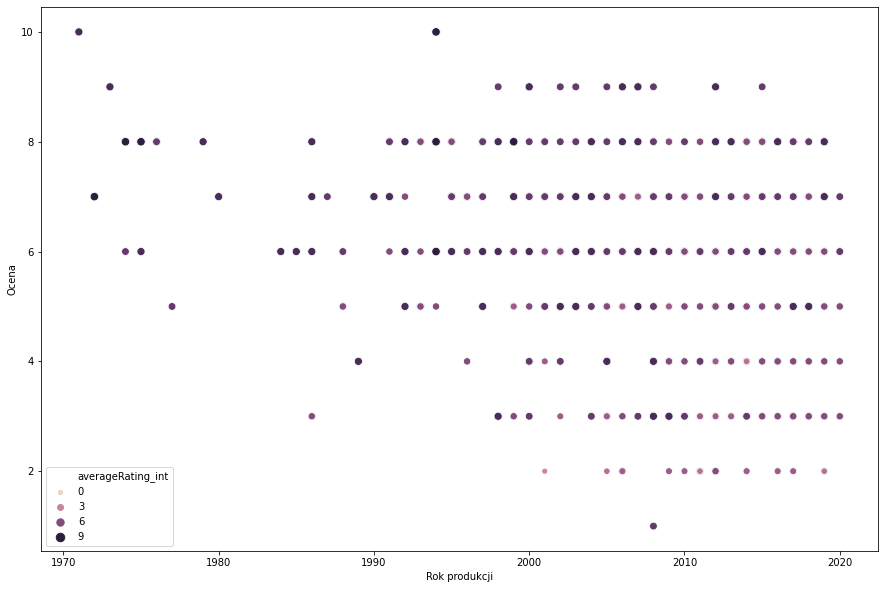

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

sns.scatterplot(x=oceny_imdb2["Rok produkcji"], 
                y=oceny_imdb2["Ocena"],
                size = oceny_imdb2["averageRating_int"],
                hue= oceny_imdb2["averageRating_int"],
                marker="o")

In [71]:
df = oceny_imdb2.drop(columns=['Rok produkcji', 'budget', 'boxoffice', 'ID', 'Gatunek', 'Kraj produkcji', 'Tytuł polski', 'Tytuł oryginalny', 'originalTitle', 'startYear', 'genre_eng', 'tconst', 'titleType', 'primaryTitle', 'isAdult', 'endYear', 'runtimeMinutes', 'genres', 'similarity', 'averageRating_int'])
df.reset_index()
df['numVotes'] = df['numVotes'].fillna(0)
df['numVotes'].isna().sum()


0

In [72]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns


missing_values_table(df)

Your selected dataframe has 171 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## test + train split

In [73]:
X = df.drop(['Ocena'], axis=1)
y = df.loc[:, 'Ocena']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

print("Zbiór treningowy:", train_X.shape, train_y.shape)
print("Zbiór testowy:", test_X.shape, test_y.shape)


Zbiór treningowy: (958, 170) (958,)
Zbiór testowy: (240, 170) (240,)


## DecisionTreeClassifier

In [74]:
tree = DecisionTreeClassifier(
  max_depth=2 
)

rfe = RFE(tree, 4)
X = rfe.fit_transform(X, y)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

tree.fit(train_X, train_y)
predicted_y = tree.predict(test_X)

precision = precision_score(test_y, predicted_y, average="micro")
print("Precision: {:.2f}".format(precision))

accuracy = accuracy_score(test_y, predicted_y)
print("Accuracy: {:.2f}".format(accuracy))

fone_score = f1_score(test_y, predicted_y, average="micro")
print("F1: {:.2f}".format(fone_score))

print ('Report : ') 
print (classification_report(test_y, predicted_y)) 

Precision: 0.29
Accuracy: 0.29
F1: 0.29
Report : 
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.14      0.30      0.19        20
         4.0       0.00      0.00      0.00        28
         5.0       0.18      0.35      0.24        31
         6.0       0.43      0.42      0.43        71
         7.0       0.35      0.45      0.39        51
         8.0       0.00      0.00      0.00        28
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1

    accuracy                           0.29       240
   macro avg       0.12      0.17      0.14       240
weighted avg       0.24      0.29      0.26       240



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RandomForestClassifier

In [75]:
classifier = RandomForestClassifier() 

classifier = classifier.fit(train_X, train_y) 
predicted_y = classifier.predict(test_X) 

print ('Accuracy Score : ', accuracy_score(test_y, predicted_y)) 
print ('Report : ') 
print (classification_report(test_y, predicted_y)) 

Accuracy Score :  0.225
Report : 
              precision    recall  f1-score   support

         2.0       0.40      0.22      0.29         9
         3.0       0.09      0.10      0.09        20
         4.0       0.19      0.14      0.16        28
         5.0       0.13      0.16      0.14        31
         6.0       0.29      0.28      0.29        71
         7.0       0.23      0.29      0.26        51
         8.0       0.32      0.21      0.26        28
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1

    accuracy                           0.23       240
   macro avg       0.18      0.16      0.17       240
weighted avg       0.23      0.23      0.23       240



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNeighborsClassifier

In [76]:
classifier = KNeighborsClassifier()

classifier = classifier.fit(train_X, train_y)
predicted_y = classifier.predict(test_X)

print ('Accuracy Score : ', accuracy_score(test_y, predicted_y)) 
print ('Report : ') 
print (classification_report(test_y, predicted_y)) 

Accuracy Score :  0.16666666666666666
Report : 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         9
         3.0       0.07      0.10      0.09        20
         4.0       0.08      0.04      0.05        28
         5.0       0.13      0.23      0.16        31
         6.0       0.25      0.27      0.26        71
         7.0       0.17      0.16      0.16        51
         8.0       0.33      0.11      0.16        28
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1

    accuracy                           0.17       240
   macro avg       0.10      0.09      0.09       240
weighted avg       0.18      0.17      0.16       240



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVC

In [77]:
classifier = SVC()

classifier = classifier.fit(train_X, train_y)
predicted_y = classifier.predict(test_X)

print ('Accuracy Score : ', accuracy_score(test_y, predicted_y)) 
print ('Report : ') 
print (classification_report(test_y, predicted_y)) 

Accuracy Score :  0.275
Report : 
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00        20
         4.0       0.00      0.00      0.00        28
         5.0       0.00      0.00      0.00        31
         6.0       0.28      0.65      0.39        71
         7.0       0.26      0.39      0.31        51
         8.0       0.00      0.00      0.00        28
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1

    accuracy                           0.28       240
   macro avg       0.06      0.12      0.08       240
weighted avg       0.14      0.28      0.18       240



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
